In [34]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cbook

In [35]:
# 7/9 tasks
# Objective: Characterize length of fs-peptides resulting from single-unit nsertion and deletion in repetitive DNA seqs
# 1. Isolate fs-peptides
# 2. Calculate fs-peptide length
# 3. Categorize by repeat type
# 4. Generate sum stats -> for both insertions and deletions, calculate set of sum stats for fs-peptide lengths within each repeat category
# 5. stratify analysis based on repeat's location relative to last exon, partition into proximal and distal groups


In [36]:
df = pl.read_csv("output_novel_peptides.v1.tsv", separator="\t")
print(df.head)
print(df.shape)

# how data was generated: when fs-mutation identified, 12 aa prior was extracted for context, then go on until either stop codon or end of coding region
# if reached end of coding region without hitting a stop codon, no "*" marked

<bound method DataFrame.head of shape: (8_903, 5)
┌────────┬─────────┬─────────────────────┬────────────────────────────┬────────────────────────────┐
│ Gene   ┆ Repeats ┆ Repeat_loc2LastExon ┆ Mutant_Peptide_minus_1     ┆ Mutant_Peptide_plus_1      │
│ ---    ┆ ---     ┆ ---                 ┆ ---                        ┆ ---                        │
│ str    ┆ str     ┆ str                 ┆ str                        ┆ str                        │
╞════════╪═════════╪═════════════════════╪════════════════════════════╪════════════════════════════╡
│ OR4F5  ┆ CTACA-3 ┆ +420                ┆ DRYIAICKPLHY:NYVWQRMCRHYGC ┆ YIAICKPLHYTT:LQLCVATHVSALW │
│        ┆         ┆                     ┆ HMGN…                      ┆ LSHG…                      │
│ SAMD11 ┆ GC-4    ┆ -692                ┆ ADLLRQKELESA:PTAAGARDRPAPQ ┆ DLLRQKELESAR:AHSCWRPRPPCAP │
│        ┆         ┆                     ┆ RRRR…                      ┆ TTAP…                      │
│ AGRN   ┆ GC-4    ┆ -5882               

In [37]:
print(df[0, 3])
print(df[0, 4])

DRYIAICKPLHY:NYVWQRMCRHYGCHMGNWLSPFGEPVGVCRALTLLWSQ*
YIAICKPLHYTT:LQLCVATHVSALWLSHGELAFSIR*


In [38]:
# isolate peptide from str columns using regex to extract sequence starting with ":" and ending with "*" or if it doesn't have "*", go to end
isolated_fspep = df.with_columns([
    pl.when(pl.col("Mutant_Peptide_minus_1").str.contains(r"\*"))
      .then(pl.col("Mutant_Peptide_minus_1").str.extract(r":(.*)\*"))
      .otherwise(pl.lit("no stop codon"))
      .alias("fs_peptide_minus"),

    pl.when(pl.col("Mutant_Peptide_plus_1").str.contains(r"\*"))
      .then(pl.col("Mutant_Peptide_plus_1").str.extract(r":(.*)\*"))
      .otherwise(pl.lit("no stop codon"))
      .alias("fs_peptide_plus")
])
isolated_fspep


Gene,Repeats,Repeat_loc2LastExon,Mutant_Peptide_minus_1,Mutant_Peptide_plus_1,fs_peptide_minus,fs_peptide_plus
str,str,str,str,str,str,str
"""OR4F5""","""CTACA-3""","""+420""","""DRYIAICKPLHY:NYVWQRMCRHYGCHMGN…","""YIAICKPLHYTT:LQLCVATHVSALWLSHG…","""NYVWQRMCRHYGCHMGNWLSPFGEPVGVCR…","""LQLCVATHVSALWLSHGELAFSIR"""
"""SAMD11""","""GC-4""","""-692""","""ADLLRQKELESA:PTAAGARDRPAPQRRRR…","""DLLRQKELESAR:AHSCWRPRPPCAPTTAP…","""PTAAGARDRPAPQRRRRGAAAARGPAGAEP…","""AHSCWRPRPPCAPTTAPRSCSGAGPCWC"""
"""AGRN""","""GC-4""","""-5882""","""LPGAGGTCPERA:GAARGGGERGAHRDGGG…","""LPGAGGTCPERA:RWSGARRRRTWCSPGRW…","""GAARGGGERGAHRDGGGDPQRGPGAAHVLL…","""RWSGARRRRTWCSPGRWRRSSTWTRCSTRT…"
"""AGRN""","""TG-4""","""-5357""","""KKSPCPSVVAPV:WVGRLHLQQRMRAAAGA…","""KSPCPSVVAPVC:VGRTPPPTATNASCSGR…","""WVGRLHLQQRMRAAAGAVQPAAPHPPAQPR…","""VGRTPPPTATNASCSGRSAASSAASACSAA…"
"""AGRN""","""GT-5""","""-4130""","""AFGAVCSAGQCV:SPV*""","""FGAVCSAGQCVC:VPGVSTPRPAPCVAATV…","""SPV""","""VPGVSTPRPAPCVAATVSPTAVPASYGKPP…"
…,…,…,…,…,…,…
"""KDM5D""","""TG-5""","""-747""","""SLMASSPTSICV:WAGASWGGSSAV*""","""LMASSPTSICVC:VGRCQLGWEFCSVTCVR…","""WAGASWGGSSAV""","""VGRCQLGWEFCSVTCVRTGSMGSVCQCPIS…"
"""KDM5D""","""GT-4""","""-673""","""LCQDWFHGQCVS:APSPHLSKAQSHFISTA…","""DLCQDWFHGQCV:CQCPISSPLQSPVSLHL…","""APSPHLSKAQSHFISTASLVGMGHKIPVST…","""CQCPISSPLQSPVSLHLHC"""
"""RPS4Y2""","""AG-4""","""+59""","""GKGIRLTIAEER:QEAGCQTEQWL""","""GKGIRLTIAEER:ETRGWLPNRAVA""","""no stop codon""","""no stop codon"""


In [39]:
# get lengths of the strings in the fs_peptide_minus and fs_peptide_plus columns in polars
isolated_fspep = isolated_fspep.with_columns([
    pl.when(pl.col("fs_peptide_minus") != "no stop codon")
      .then(pl.col("fs_peptide_minus").str.len_chars())
      .otherwise(None)
      .alias("minus_len"),

    pl.when(pl.col("fs_peptide_plus") != "no stop codon")
      .then(pl.col("fs_peptide_plus").str.len_chars())
      .otherwise(None)
      .alias("plus_len")
])
isolated_fspep

Gene,Repeats,Repeat_loc2LastExon,Mutant_Peptide_minus_1,Mutant_Peptide_plus_1,fs_peptide_minus,fs_peptide_plus,minus_len,plus_len
str,str,str,str,str,str,str,u32,u32
"""OR4F5""","""CTACA-3""","""+420""","""DRYIAICKPLHY:NYVWQRMCRHYGCHMGN…","""YIAICKPLHYTT:LQLCVATHVSALWLSHG…","""NYVWQRMCRHYGCHMGNWLSPFGEPVGVCR…","""LQLCVATHVSALWLSHGELAFSIR""",38,24
"""SAMD11""","""GC-4""","""-692""","""ADLLRQKELESA:PTAAGARDRPAPQRRRR…","""DLLRQKELESAR:AHSCWRPRPPCAPTTAP…","""PTAAGARDRPAPQRRRRGAAAARGPAGAEP…","""AHSCWRPRPPCAPTTAPRSCSGAGPCWC""",81,28
"""AGRN""","""GC-4""","""-5882""","""LPGAGGTCPERA:GAARGGGERGAHRDGGG…","""LPGAGGTCPERA:RWSGARRRRTWCSPGRW…","""GAARGGGERGAHRDGGGDPQRGPGAAHVLL…","""RWSGARRRRTWCSPGRWRRSSTWTRCSTRT…",67,39
"""AGRN""","""TG-4""","""-5357""","""KKSPCPSVVAPV:WVGRLHLQQRMRAAAGA…","""KSPCPSVVAPVC:VGRTPPPTATNASCSGR…","""WVGRLHLQQRMRAAAGAVQPAAPHPPAQPR…","""VGRTPPPTATNASCSGRSAASSAASACSAA…",107,41
"""AGRN""","""GT-5""","""-4130""","""AFGAVCSAGQCV:SPV*""","""FGAVCSAGQCVC:VPGVSTPRPAPCVAATV…","""SPV""","""VPGVSTPRPAPCVAATVSPTAVPASYGKPP…",3,111
…,…,…,…,…,…,…,…,…
"""KDM5D""","""TG-5""","""-747""","""SLMASSPTSICV:WAGASWGGSSAV*""","""LMASSPTSICVC:VGRCQLGWEFCSVTCVR…","""WAGASWGGSSAV""","""VGRCQLGWEFCSVTCVRTGSMGSVCQCPIS…",12,43
"""KDM5D""","""GT-4""","""-673""","""LCQDWFHGQCVS:APSPHLSKAQSHFISTA…","""DLCQDWFHGQCV:CQCPISSPLQSPVSLHL…","""APSPHLSKAQSHFISTASLVGMGHKIPVST…","""CQCPISSPLQSPVSLHLHC""",57,19
"""RPS4Y2""","""AG-4""","""+59""","""GKGIRLTIAEER:QEAGCQTEQWL""","""GKGIRLTIAEER:ETRGWLPNRAVA""","""no stop codon""","""no stop codon""",null,null


In [40]:
# check location of mutations (Repeat_loc2LastExon) that cause there to be no stop codon
no_stop_codons = isolated_fspep.filter(
    pl.col("minus_len").is_null() | pl.col("plus_len").is_null()
)
no_stop_codons = no_stop_codons.select(pl.col("Repeat_loc2LastExon")).cast(pl.Int64).to_series().to_list()
pd.Series(no_stop_codons).describe()


count       829.000000
mean       -110.564536
std        6997.491308
min     -122505.000000
25%          27.000000
50%         150.000000
75%         575.000000
max       15249.000000
dtype: float64

In [41]:

# since we are using 9-mer peptides, can include first 8 wt aa in the analysis
# in this dataset, the 12 aa preceeding the mut are included, so we can just remove the first 4 chars and the colon

TARGET_LEN = 9
# we cut off (12 - TARGET_LEN + 1)

deletion_seqs = (
    isolated_fspep
    .select(
        pl.col("Mutant_Peptide_minus_1")
        .cast(pl.String)
        .str.replace_all(":", "")
        .str.slice(12 - TARGET_LEN + 1)
        .alias("cleaned")
    )
    .drop_nulls()
    .filter(pl.col("cleaned") != "")
    .to_series()
    .to_list()
)

insertion_seqs = (
    isolated_fspep
    .select(
        pl.col("Mutant_Peptide_plus_1")
        .cast(pl.String)
        .str.replace_all(":", "")
        .str.slice(12 - TARGET_LEN + 1)
        .alias("cleaned")
    )
    .drop_nulls()
    .filter(pl.col("cleaned") != "")
    .to_series()
    .to_list()
)

all_fs_peptides = deletion_seqs + insertion_seqs
all_fs_peptides

['AICKPLHYNYVWQRMCRHYGCHMGNWLSPFGEPVGVCRALTLLWSQ*',
 'RQKELESAPTAAGARDRPAPQRRRRGAAAARGPAGAEPRRGATAGPAPPGAPGLRTPHPVPGLCPASPPEGGSRPCLSAAQRVQGDDGG*',
 'GGTCPERAGAARGGGERGAHRDGGGDPQRGPGAAHVLLQGSGLAVLEGQRPGGPGEPAGRRQQGGDQRLWRPPHL*',
 'CPSVVAPVWVGRLHLQQRMRAAAGAVQPAAPHPPAQPRAVRLAGPLLQRDLQLRQHLCALGRRADGLVPVPRDLPWRPRGDRLRQRRRRLPRRVPAPAPRLRPPGECLQEVRRPL*',
 'VCSAGQCVSPV*',
 'SQALPAPPAPSPWLPAVPHTARPPLRPHHDLGPLPASPGPPCGPC*',
 'KASKVPGGSRPGWKRTQQRPPWRTSRGQAQDTSGHRGS*',
 'RLDLKHERGLFHLV*',
 'ANHSSTRESSQQGGE*',
 'PPPPAPARRRLPGSAGGQRAPRRRAPQRDPQHVACAARGPGRRVGALCRGHGRPGRRGAARPGAGAGAARGPAAAARAARRLRKPHGQGAGHAGLAGRARGLRVRAQGGRRLLRAAGRAAGRAARPRARAPPPPLLGLLLGPRPRQAGGALARGRLATLRLLPALRAGRRLRALGRPGALPAPQPRLPARLAQRGRVSGRLAGAGGRPAGARPALRHRIPVPRLQQPVPGDAQAEPGGHAGEARDAGARGPPVQARGAAAPVLRVRLVRAALAVLPEKGGHPL',
 'LRARDVVCSHLY*',
 'PASGSVRALSCVLPVRGHRL*',
 'VLAEALNTPAAPGHQGPAGLPSAQRLPRSSRSHVPDLPVPPGHWLSPA*',
 'DVVDWLYTRGGLQGAAGGPEVRQQLAEARLPAAHGQQDHLLRAVLLRLRGSLQQSRHPEPQQWLQWDFGSGHAGPAAPPGCPLASGSGLPLPVPGTPTLLPACLPGPGL*

In [42]:
# group based on repeat type
grouped = isolated_fspep.with_columns(
    repeat_len = pl.col("Repeats").str.extract(r"(.*[A-Z])").str.len_chars()
)
grouped

Gene,Repeats,Repeat_loc2LastExon,Mutant_Peptide_minus_1,Mutant_Peptide_plus_1,fs_peptide_minus,fs_peptide_plus,minus_len,plus_len,repeat_len
str,str,str,str,str,str,str,u32,u32,u32
"""OR4F5""","""CTACA-3""","""+420""","""DRYIAICKPLHY:NYVWQRMCRHYGCHMGN…","""YIAICKPLHYTT:LQLCVATHVSALWLSHG…","""NYVWQRMCRHYGCHMGNWLSPFGEPVGVCR…","""LQLCVATHVSALWLSHGELAFSIR""",38,24,5
"""SAMD11""","""GC-4""","""-692""","""ADLLRQKELESA:PTAAGARDRPAPQRRRR…","""DLLRQKELESAR:AHSCWRPRPPCAPTTAP…","""PTAAGARDRPAPQRRRRGAAAARGPAGAEP…","""AHSCWRPRPPCAPTTAPRSCSGAGPCWC""",81,28,2
"""AGRN""","""GC-4""","""-5882""","""LPGAGGTCPERA:GAARGGGERGAHRDGGG…","""LPGAGGTCPERA:RWSGARRRRTWCSPGRW…","""GAARGGGERGAHRDGGGDPQRGPGAAHVLL…","""RWSGARRRRTWCSPGRWRRSSTWTRCSTRT…",67,39,2
"""AGRN""","""TG-4""","""-5357""","""KKSPCPSVVAPV:WVGRLHLQQRMRAAAGA…","""KSPCPSVVAPVC:VGRTPPPTATNASCSGR…","""WVGRLHLQQRMRAAAGAVQPAAPHPPAQPR…","""VGRTPPPTATNASCSGRSAASSAASACSAA…",107,41,2
"""AGRN""","""GT-5""","""-4130""","""AFGAVCSAGQCV:SPV*""","""FGAVCSAGQCVC:VPGVSTPRPAPCVAATV…","""SPV""","""VPGVSTPRPAPCVAATVSPTAVPASYGKPP…",3,111,2
…,…,…,…,…,…,…,…,…,…
"""KDM5D""","""TG-5""","""-747""","""SLMASSPTSICV:WAGASWGGSSAV*""","""LMASSPTSICVC:VGRCQLGWEFCSVTCVR…","""WAGASWGGSSAV""","""VGRCQLGWEFCSVTCVRTGSMGSVCQCPIS…",12,43,2
"""KDM5D""","""GT-4""","""-673""","""LCQDWFHGQCVS:APSPHLSKAQSHFISTA…","""DLCQDWFHGQCV:CQCPISSPLQSPVSLHL…","""APSPHLSKAQSHFISTASLVGMGHKIPVST…","""CQCPISSPLQSPVSLHLHC""",57,19,2
"""RPS4Y2""","""AG-4""","""+59""","""GKGIRLTIAEER:QEAGCQTEQWL""","""GKGIRLTIAEER:ETRGWLPNRAVA""","""no stop codon""","""no stop codon""",null,null,2


In [43]:
# further annotation of proximal or distal

#dist_strat = grouped.with_columns(
#    dist_group = "Proximal" if (pl.col("Repeat_loc2LastExon").str.extract(r"(.*[0-9])").cast(pl.Int64) > -51) else "Distal"
#)

dist_strat = grouped.with_columns(
    pl.when(pl.col("Repeat_loc2LastExon").str.extract(r"(.*[0-9])").cast(pl.Int64) >= -50)
    .then(pl.lit("Downstream"))
    .otherwise(pl.lit("Upstream"))
    .alias("dist_group")
)
dist_strat

Gene,Repeats,Repeat_loc2LastExon,Mutant_Peptide_minus_1,Mutant_Peptide_plus_1,fs_peptide_minus,fs_peptide_plus,minus_len,plus_len,repeat_len,dist_group
str,str,str,str,str,str,str,u32,u32,u32,str
"""OR4F5""","""CTACA-3""","""+420""","""DRYIAICKPLHY:NYVWQRMCRHYGCHMGN…","""YIAICKPLHYTT:LQLCVATHVSALWLSHG…","""NYVWQRMCRHYGCHMGNWLSPFGEPVGVCR…","""LQLCVATHVSALWLSHGELAFSIR""",38,24,5,"""Downstream"""
"""SAMD11""","""GC-4""","""-692""","""ADLLRQKELESA:PTAAGARDRPAPQRRRR…","""DLLRQKELESAR:AHSCWRPRPPCAPTTAP…","""PTAAGARDRPAPQRRRRGAAAARGPAGAEP…","""AHSCWRPRPPCAPTTAPRSCSGAGPCWC""",81,28,2,"""Upstream"""
"""AGRN""","""GC-4""","""-5882""","""LPGAGGTCPERA:GAARGGGERGAHRDGGG…","""LPGAGGTCPERA:RWSGARRRRTWCSPGRW…","""GAARGGGERGAHRDGGGDPQRGPGAAHVLL…","""RWSGARRRRTWCSPGRWRRSSTWTRCSTRT…",67,39,2,"""Upstream"""
"""AGRN""","""TG-4""","""-5357""","""KKSPCPSVVAPV:WVGRLHLQQRMRAAAGA…","""KSPCPSVVAPVC:VGRTPPPTATNASCSGR…","""WVGRLHLQQRMRAAAGAVQPAAPHPPAQPR…","""VGRTPPPTATNASCSGRSAASSAASACSAA…",107,41,2,"""Upstream"""
"""AGRN""","""GT-5""","""-4130""","""AFGAVCSAGQCV:SPV*""","""FGAVCSAGQCVC:VPGVSTPRPAPCVAATV…","""SPV""","""VPGVSTPRPAPCVAATVSPTAVPASYGKPP…",3,111,2,"""Upstream"""
…,…,…,…,…,…,…,…,…,…,…
"""KDM5D""","""TG-5""","""-747""","""SLMASSPTSICV:WAGASWGGSSAV*""","""LMASSPTSICVC:VGRCQLGWEFCSVTCVR…","""WAGASWGGSSAV""","""VGRCQLGWEFCSVTCVRTGSMGSVCQCPIS…",12,43,2,"""Upstream"""
"""KDM5D""","""GT-4""","""-673""","""LCQDWFHGQCVS:APSPHLSKAQSHFISTA…","""DLCQDWFHGQCV:CQCPISSPLQSPVSLHL…","""APSPHLSKAQSHFISTASLVGMGHKIPVST…","""CQCPISSPLQSPVSLHLHC""",57,19,2,"""Upstream"""
"""RPS4Y2""","""AG-4""","""+59""","""GKGIRLTIAEER:QEAGCQTEQWL""","""GKGIRLTIAEER:ETRGWLPNRAVA""","""no stop codon""","""no stop codon""",null,null,2,"""Downstream"""


In [44]:
# generate sum stats -> mean, median, range for groupings -> minus and plus, each repeat len type
# box plots

# establish data to plot

plotting = dist_strat.select("minus_len", "plus_len", "repeat_len", "dist_group")
print(plotting.describe())
plotting2 = plotting.clone()


shape: (9, 5)
┌────────────┬───────────┬───────────┬────────────┬────────────┐
│ statistic  ┆ minus_len ┆ plus_len  ┆ repeat_len ┆ dist_group │
│ ---        ┆ ---       ┆ ---       ┆ ---        ┆ ---        │
│ str        ┆ f64       ┆ f64       ┆ f64        ┆ str        │
╞════════════╪═══════════╪═══════════╪════════════╪════════════╡
│ count      ┆ 8369.0    ┆ 8321.0    ┆ 8903.0     ┆ 8903       │
│ null_count ┆ 534.0     ┆ 582.0     ┆ 0.0        ┆ 0          │
│ mean       ┆ 23.875493 ┆ 27.609182 ┆ 2.041784   ┆ null       │
│ std        ┆ 34.33342  ┆ 36.735844 ┆ 0.738611   ┆ null       │
│ min        ┆ 0.0       ┆ 0.0       ┆ 1.0        ┆ Downstream │
│ 25%        ┆ 4.0       ┆ 6.0       ┆ 2.0        ┆ null       │
│ 50%        ┆ 12.0      ┆ 16.0      ┆ 2.0        ┆ null       │
│ 75%        ┆ 29.0      ┆ 35.0      ┆ 2.0        ┆ null       │
│ max        ┆ 448.0     ┆ 733.0     ┆ 5.0        ┆ Upstream   │
└────────────┴───────────┴───────────┴────────────┴────────────┘


In [45]:
temp = plotting.filter((pl.col("dist_group") == "Downstream"))
temp.head

<bound method DataFrame.head of shape: (2_423, 4)
┌───────────┬──────────┬────────────┬────────────┐
│ minus_len ┆ plus_len ┆ repeat_len ┆ dist_group │
│ ---       ┆ ---      ┆ ---        ┆ ---        │
│ u32       ┆ u32      ┆ u32        ┆ str        │
╞═══════════╪══════════╪════════════╪════════════╡
│ 38        ┆ 24       ┆ 5          ┆ Downstream │
│ null      ┆ 20       ┆ 2          ┆ Downstream │
│ null      ┆ 127      ┆ 2          ┆ Downstream │
│ null      ┆ 3        ┆ 2          ┆ Downstream │
│ 4         ┆ 21       ┆ 2          ┆ Downstream │
│ …         ┆ …        ┆ …          ┆ …          │
│ null      ┆ null     ┆ 2          ┆ Downstream │
│ 1         ┆ 4        ┆ 2          ┆ Downstream │
│ 1         ┆ 4        ┆ 2          ┆ Downstream │
│ null      ┆ null     ┆ 2          ┆ Downstream │
│ 1         ┆ 4        ┆ 2          ┆ Downstream │
└───────────┴──────────┴────────────┴────────────┘>

In [46]:
# generate sum stats for overall (not stratified by downstream vs. upstream)
# needed - average peptide length and SD for insertion and deletion, for each repeat type

def printStats(df, repeat_length, type):
    print(f"Stats for {type} fs-peptides with repeat length {repeat_length}:")
    if type != "All":
        subset = df.filter(
            (pl.col("dist_group") == type) & (pl.col("repeat_len") == repeat_length)
        )
    else:
        subset = df.filter(pl.col("repeat_len") == repeat_length)
    mean_minus = subset.select(pl.col("minus_len").mean()).to_numpy()[0][0]
    mean_plus = subset.select(pl.col("plus_len").mean()).to_numpy()[0][0]
    sd_minus = subset.select(pl.col("minus_len").std()).to_numpy()[0][0]
    sd_plus = subset.select(pl.col("plus_len").std()).to_numpy()[0][0]
    
    print(f"  Mean Insertion: {mean_plus}, SD: {sd_plus}")
    print(f"  Mean Deletion: {mean_minus}, SD: {sd_minus}")

printStats(plotting, 1, "Downstream")
printStats(plotting, 2, "Downstream")
printStats(plotting, 4, "Downstream")
printStats(plotting, 5, "Downstream")

printStats(plotting, 1, "Upstream")
printStats(plotting, 2, "Upstream")
printStats(plotting, 4, "Upstream")
printStats(plotting, 5, "Upstream")

printStats(plotting, 1, "All")
printStats(plotting, 2, "All")
printStats(plotting, 4, "All")
printStats(plotting, 5, "All")


Stats for Downstream fs-peptides with repeat length 1:
  Mean Insertion: 13.601694915254237, SD: 21.45778233291951
  Mean Deletion: 22.449152542372882, SD: 29.362038730777794
Stats for Downstream fs-peptides with repeat length 2:
  Mean Insertion: 32.289021164021165, SD: 40.998625485436925
  Mean Deletion: 21.166666666666668, SD: 34.512649015351954
Stats for Downstream fs-peptides with repeat length 4:
  Mean Insertion: 27.364963503649633, SD: 38.735505052252385
  Mean Deletion: 37.56296296296296, SD: 49.98710392010636
Stats for Downstream fs-peptides with repeat length 5:
  Mean Insertion: 35.851851851851855, SD: 54.56097767544388
  Mean Deletion: 47.806451612903224, SD: 61.68815086375378
Stats for Upstream fs-peptides with repeat length 1:
  Mean Insertion: 16.04384133611691, SD: 21.2253214905229
  Mean Deletion: 21.26255230125523, SD: 28.31248775176065
Stats for Upstream fs-peptides with repeat length 2:
  Mean Insertion: 28.70515170026471, SD: 37.195282149592245
  Mean Deletion: 24

In [47]:
temp = plotting.clone()
# modify temporarily to combine the insertion and deletion columns
stacked_df = pl.concat([
    temp.select([
        pl.col("minus_len").alias("fs_peptide_len"),
        pl.col("repeat_len"),
        pl.col("dist_group")
    ]),
    temp.select([
        pl.col("plus_len").alias("fs_peptide_len"),
        pl.col("repeat_len"),
        pl.col("dist_group")
    ])
])
#stacked_df = stacked_df.drop_nulls()
stacked_df.shape


(17806, 3)

In [48]:
def printStats2(df, repeat_length, type):
    print(f"Stats for {type} fs-peptides with repeat length {repeat_length}:")
    if type != "All":
        subset = df.filter(
            (pl.col("dist_group") == type) & (pl.col("repeat_len") == repeat_length)
        )
    else:
        subset = df.filter(pl.col("repeat_len") == repeat_length)
    mean_all = subset.select(pl.col("fs_peptide_len").mean()).to_numpy()[0][0]
    sd_all = subset.select(pl.col("fs_peptide_len").std()).to_numpy()[0][0]
    
    print(f"  Mean : {mean_all}, SD: {sd_all}")

printStats2(stacked_df, 1, "Downstream")
printStats2(stacked_df, 2, "Downstream")
printStats2(stacked_df, 4, "Downstream")
printStats2(stacked_df, 5, "Downstream")
printStats2(stacked_df, 1, "Upstream")
printStats2(stacked_df, 2, "Upstream")
printStats2(stacked_df, 4, "Upstream")
printStats2(stacked_df, 5, "Upstream")
printStats2(stacked_df, 1, "All")
printStats2(stacked_df, 2, "All")
printStats2(stacked_df, 4, "All")
printStats2(stacked_df, 5, "All")




Stats for Downstream fs-peptides with repeat length 1:
  Mean : 18.02542372881356, SD: 26.06702511069414
Stats for Downstream fs-peptides with repeat length 2:
  Mean : 26.640950520833332, SD: 38.244466203474374
Stats for Downstream fs-peptides with repeat length 4:
  Mean : 32.4264705882353, SD: 44.884375005124085
Stats for Downstream fs-peptides with repeat length 5:
  Mean : 42.241379310344826, SD: 58.28312937715296
Stats for Upstream fs-peptides with repeat length 1:
  Mean : 18.650470219435736, SD: 25.14671185010773
Stats for Upstream fs-peptides with repeat length 2:
  Mean : 26.44914995418915, SD: 35.97820041569501
Stats for Upstream fs-peptides with repeat length 4:
  Mean : 28.831182795698926, SD: 35.922690816521246
Stats for Upstream fs-peptides with repeat length 5:
  Mean : 37.65771812080537, SD: 44.014704516522244
Stats for All fs-peptides with repeat length 1:
  Mean : 18.526823134953897, SD: 25.327099392862145
Stats for All fs-peptides with repeat length 2:
  Mean : 26.4

In [52]:
stacked_df.head()

fs_peptide_len,repeat_len,dist_group
u32,u32,str
38,5,"""Downstream"""
81,2,"""Upstream"""
67,2,"""Upstream"""
107,2,"""Upstream"""
3,2,"""Upstream"""


In [55]:
# in stacked_df, nulls correspond to no stop codon

downstream_summary = stacked_df.filter(pl.col("dist_group") == "Downstream").select([
    pl.col("fs_peptide_len").is_null().sum().alias("no_stop_codon"),
    (pl.col("fs_peptide_len") == 0).sum().alias("len_0"),
    (pl.col("fs_peptide_len").is_between(1, 15)).sum().alias("len_1_15"),
    (pl.col("fs_peptide_len").is_between(16, 50)).sum().alias("len_16_50"),
    (pl.col("fs_peptide_len") > 50).sum().alias("len_50_plus")
])

print((f"Downstream Summary: {downstream_summary}"))

# for table, get number of peptides that have no stop codon, len 0, len 1-15, len 16-50, and len 50+
downstream_summary_strat = (
    stacked_df
    .filter(pl.col("dist_group")=="Downstream")
    .group_by("repeat_len")
    .agg([
        pl.col("fs_peptide_len").is_null().sum().alias("no_stop_codon"),
        (pl.col("fs_peptide_len") == 0).sum().alias("len_0"),
        pl.col("fs_peptide_len").is_between(1, 15).sum().alias("len_1_15"),
        pl.col("fs_peptide_len").is_between(16, 50).sum().alias("len_16_50"),
        (pl.col("fs_peptide_len") > 50).sum().alias("len_50_plus")
    ])
)

print((f"Downstream Summary Strat: {downstream_summary_strat}"))

upstream_summary = stacked_df.filter(pl.col("dist_group") == "Upstream").select([
    pl.col("fs_peptide_len").is_null().sum().alias("no_stop_codon"),
    (pl.col("fs_peptide_len") == 0).sum().alias("len_0"),
    (pl.col("fs_peptide_len").is_between(1, 15)).sum().alias("len_1_15"),
    (pl.col("fs_peptide_len").is_between(16, 50)).sum().alias("len_16_50"),
    (pl.col("fs_peptide_len") > 50).sum().alias("len_50_plus")
])

print((f"Upstream Summary: {upstream_summary}"))

# for table, get number of peptides that have no stop codon, len 0, len 1-15, len 16-50, and len 50+
upstream_summary_strat = (
    stacked_df
    .filter(pl.col("dist_group")=="Upstream")
    .group_by("repeat_len")
    .agg([
        pl.col("fs_peptide_len").is_null().sum().alias("no_stop_codon"),
        (pl.col("fs_peptide_len") == 0).sum().alias("len_0"),
        pl.col("fs_peptide_len").is_between(1, 15).sum().alias("len_1_15"),
        pl.col("fs_peptide_len").is_between(16, 50).sum().alias("len_16_50"),
        (pl.col("fs_peptide_len") > 50).sum().alias("len_50_plus")
    ])
)

print((f"Upstream Summary Strat: {upstream_summary_strat}"))



Downstream Summary: shape: (1, 5)
┌───────────────┬───────┬──────────┬───────────┬─────────────┐
│ no_stop_codon ┆ len_0 ┆ len_1_15 ┆ len_16_50 ┆ len_50_plus │
│ ---           ┆ ---   ┆ ---      ┆ ---       ┆ ---         │
│ u32           ┆ u32   ┆ u32      ┆ u32       ┆ u32         │
╞═══════════════╪═══════╪══════════╪═══════════╪═════════════╡
│ 972           ┆ 164   ┆ 1965     ┆ 1183      ┆ 562         │
└───────────────┴───────┴──────────┴───────────┴─────────────┘
Downstream Summary Strat: shape: (4, 6)
┌────────────┬───────────────┬───────┬──────────┬───────────┬─────────────┐
│ repeat_len ┆ no_stop_codon ┆ len_0 ┆ len_1_15 ┆ len_16_50 ┆ len_50_plus │
│ ---        ┆ ---           ┆ ---   ┆ ---      ┆ ---       ┆ ---         │
│ u32        ┆ u32           ┆ u32   ┆ u32      ┆ u32       ┆ u32         │
╞════════════╪═══════════════╪═══════╪══════════╪═══════════╪═════════════╡
│ 1          ┆ 126           ┆ 14    ┆ 296      ┆ 121       ┆ 41          │
│ 4          ┆ 84            

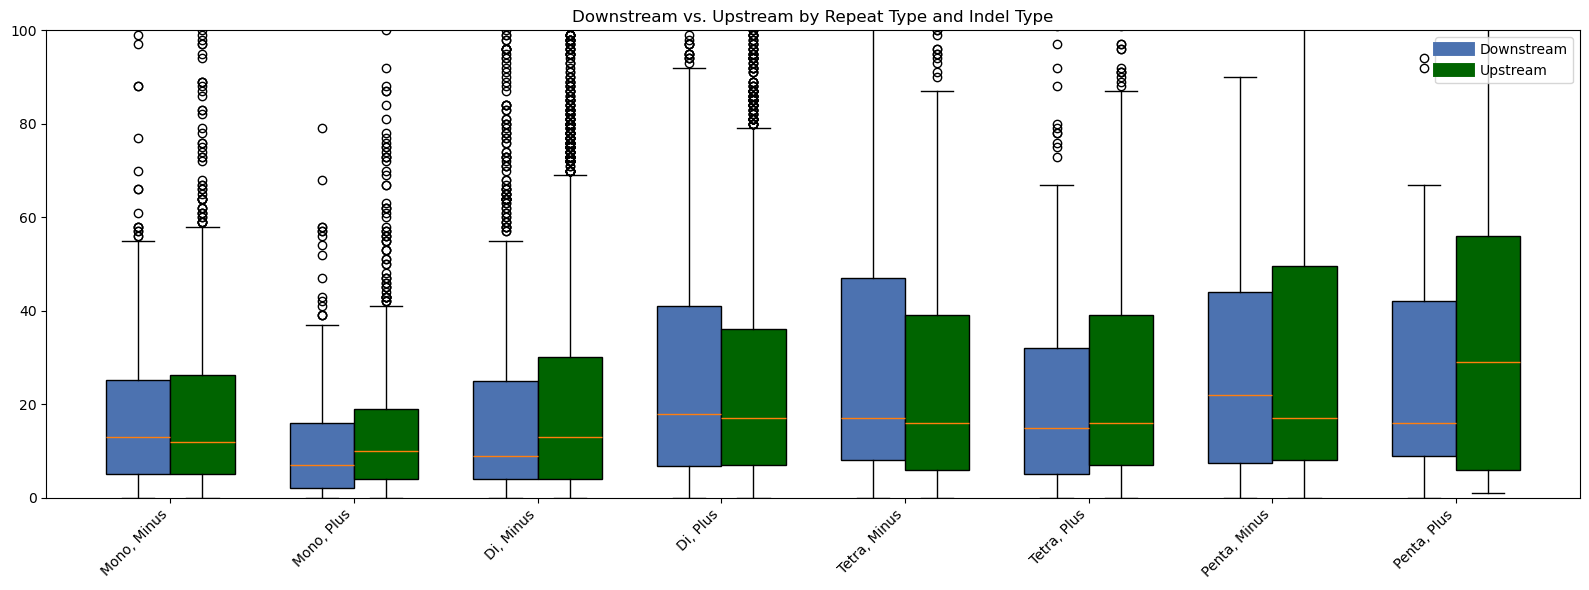

In [18]:
x_labels = ["Mono, Minus", "Mono, Plus", 
            "Di, Minus", "Di, Plus", 
            "Tetra, Minus", "Tetra, Plus", 
            "Penta, Minus", "Penta, Plus"]

repeat_lengths = [1, 2, 4, 5]

downstream_only = plotting.filter(pl.col("dist_group") == "Downstream")
upstream_only = plotting2.filter(pl.col("dist_group") == "Upstream")

downstream_plot_data = []
upstream_plot_data = []

for i in repeat_lengths:
    for col_idx in [0, 1]: # 0 is minus_len, 1 is plus_len
        ds_temp = downstream_only.filter(pl.col("repeat_len") == i)[:, col_idx].to_numpy()
        us_temp = upstream_only.filter(pl.col("repeat_len") == i)[:, col_idx].to_numpy()
        downstream_plot_data.append(ds_temp[~np.isnan(ds_temp)])
        upstream_plot_data.append(us_temp[~np.isnan(us_temp)])

all_data = []
positions = []
xtick_labels = []
width = 0.35

for i in range(len(x_labels)):
    pos = i + 1
    positions.append([pos - width/2, pos + width/2])
    all_data.append(downstream_plot_data[i])
    all_data.append(upstream_plot_data[i])
    xtick_labels.append(x_labels[i])

flat_positions = [p for pair in positions for p in pair]

plt.figure(figsize=(16, 6))
bp = plt.boxplot(all_data, positions=flat_positions, widths=width, patch_artist=True)

colors = ["#4c72b0", "#006400"] 

for i, box in enumerate(bp["boxes"]):
    color = colors[i % 2]  
    box.set(facecolor=color)

plt.xticks([np.mean(p) for p in positions], xtick_labels, rotation=45, ha='right')
plt.title("Downstream vs. Upstream by Repeat Type and Indel Type")
custom_handles = [
    plt.Line2D([0], [0], color=colors[0], lw=10),
    plt.Line2D([0], [0], color=colors[1], lw=10)
]
plt.legend(custom_handles, ["Downstream", "Upstream"], loc="upper right")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


In [32]:
# use bigMHC to predict which peptides bind to HLA-A*0201
# -m el or -m im? el model predicts peptide presentation, im predicts peptide immunogenicity

# structure input file as first column - target (HLA-A*0201), second column - peptide sequence



input_df = pl.DataFrame({
    "mhc": "HLA-A*0201",
    "pep": all_fs_peptides,
})

def extract_subpeptides(peptide):
    if peptide is None:
        return []
    peptide = peptide.strip()
    return [
        peptide[i:i+length]
        for length in range(9, 10)
        for i in range(len(peptide) - length + 1)
    ]

input_df = (
    input_df.with_columns([
        pl.col("pep").map_elements(extract_subpeptides).alias("sub_peptides")
    ])
    .explode("sub_peptides")
    .select([
        pl.col("mhc"),
        pl.col("sub_peptides").alias("pep")
    ])
)

# drop empty strings
input_df = input_df.filter(pl.col("pep") != "")

# just in case thresholding filter
input_df = input_df.filter(pl.col("pep").str.len_chars().is_between(9, 10))
print(input_df.shape)
input_df.write_csv("input.csv")

# python predict.py -i ../../input.csv -m "el" -o ../../el_output.csv.prd -d cpu -j 5
# python predict.py -i ../../input.csv -m "im" -o ../../im_output.csv.prd -d cpu -j 5

(494254, 2)


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_9449/3125284525.py:24: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  input_df.with_columns([


python predict.py --help
usage: Predict pMHC presentation or immunogenicity with BigMHC [-h] -i INPUT -m MODELS [-o OUT] [-s PSEUDOSEQS] [-d DEVICES] [-v VERBOSE] [-b MAXBAT]
[-c HDRCNT] [-a ALLELE] [-p PEPCOL] [-t TGTCOL] [-j JOBS] [-f PREFETCH] [-z SAVEATT]

options:
-h, --help show this help message and exit
-i, --input INPUT path to csv file
-m, --models MODELS Either "el" or "im" for presentation (eluted ligand) and immunogenicity prediction respectively. Or specify a colon-delimited
paths to model directories
-o, --out OUT Path to file in which to save predictions. If None, then predictions are saved to [INPUT].prd
-s, --pseudoseqs PSEUDOSEQS
CSV file mapping MHC to one-hot encoding
-d, --devices DEVICES
Comma-separated list of GPU device ids. Use "all" to use all GPUs or "cpu" to use the CPU
-v, --verbose VERBOSE
1 to enable verbose printing, 0 otherwise
-b, --maxbat MAXBAT Maxmum batch size (turn down if running out of memory). If None, we guess the max by the devices arg.
-c, --hdrcnt HDRCNT Number of header lines to skip in the input file
-a, --allele ALLELE Zero-indexed column of mhc alleles or an allele name. For example, use 0 if the first column of the input file contains an MHC
allele. You can specify an allele name to apply a specified allele to all peptides by passing an allele name in the format:
HLA-A\*02:01
-p, --pepcol PEPCOL Zero-indexed column of the input file containing peptides
-t, --tgtcol TGTCOL Zero-indexed column of the input file containing target values
-j, --jobs JOBS Number of workers for parallel data loading
-f, --prefetch PREFETCH
Number of batches to prefetch per data loader worker
-z, --saveatt SAVEATT
1 to save attention values when running predict, 0 otherwise


In [22]:
el_output_df = pl.read_csv("./el_output.csv.prd")
print(el_output_df)
print(el_output_df.select(pl.col("BigMHC_EL")).describe())

im_output_df = pl.read_csv("./im_output.csv.prd")
print(im_output_df.select(pl.col("BigMHC_IM")).describe())

# A, B, C, two copies each

# 40% OF WHITE POPULAITO HAVE HLA-A*0201, 25% in asian

# HLA-A*0201 most studied MHC molecule

shape: (322_575, 5)
┌────────────┬───────────┬──────┬─────┬───────────┐
│ mhc        ┆ pep       ┆ tgt  ┆ len ┆ BigMHC_EL │
│ ---        ┆ ---       ┆ ---  ┆ --- ┆ ---       │
│ str        ┆ str       ┆ str  ┆ i64 ┆ f64       │
╞════════════╪═══════════╪══════╪═════╪═══════════╡
│ HLA-A*0201 ┆ NYVWQRMCR ┆ null ┆ 9   ┆ 0.000031  │
│ HLA-A*0201 ┆ YVWQRMCRH ┆ null ┆ 9   ┆ 0.000048  │
│ HLA-A*0201 ┆ VWQRMCRHY ┆ null ┆ 9   ┆ 0.000024  │
│ HLA-A*0201 ┆ WQRMCRHYG ┆ null ┆ 9   ┆ 0.000018  │
│ HLA-A*0201 ┆ QRMCRHYGC ┆ null ┆ 9   ┆ 0.000007  │
│ …          ┆ …         ┆ …    ┆ …   ┆ …         │
│ HLA-A*0201 ┆ SPLQSPVSL ┆ null ┆ 9   ┆ 0.02344   │
│ HLA-A*0201 ┆ PLQSPVSLH ┆ null ┆ 9   ┆ 0.006618  │
│ HLA-A*0201 ┆ LQSPVSLHL ┆ null ┆ 9   ┆ 0.247704  │
│ HLA-A*0201 ┆ QSPVSLHLH ┆ null ┆ 9   ┆ 0.000764  │
│ HLA-A*0201 ┆ SPVSLHLHC ┆ null ┆ 9   ┆ 0.000273  │
└────────────┴───────────┴──────┴─────┴───────────┘
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ BigMHC_EL │
│ ---        ┆ ---       │
│

In [56]:

# given predicted binders, filter rows of isolated_fpep that include the 9-mer sequences in either fs_peptide_minus or fs_peptide_plus column

#predicted_binders_set = set(predicted_binders)

#filtered_fspep = isolated_fspep.filter(
#    pl.col("fs_peptide_minus").str.contains("|".join(predicted_binders_set)) |
#    pl.col("fs_peptide_plus").str.contains("|".join(predicted_binders_set))
#)

#print(filtered_fspep.head)



Run peptides through NetMHCpan4.1 server, results below

https://services.healthtech.dtu.dk/services/NetMHCpan-4.1/

In [62]:
# testing subset of 500 peptides (max submission)

temp = pl.read_csv("input.csv")
temp = temp.select(pl.col("pep"))
temp = temp.head(500)

with open("netmhcpan_submission.fasta", "w") as fasta_file:
    for i, seq in enumerate(temp["pep"]):
        header = f">seq_{i+1}"
        fasta_file.write(f"{header}\n{seq}\n")

In [78]:
# ran 8/2 with criteria Rank 0.5% for strong binder, Rank 2% for weak binder

# read results

netmhcpan_res = pl.read_csv("NetMHCpan Results.csv")
netmhcpan_res.columns = netmhcpan_res.row(0)
netmhcpan_res = netmhcpan_res.slice(1, None)

netmhcpan_res = netmhcpan_res.with_columns(
    pl.col("EL-score").cast(pl.Float64),
    pl.col("EL_Rank").cast(pl.Float64),
    pl.col("Ave").cast(pl.Float64),
    pl.col("NB").cast(pl.Int32)
)

print(netmhcpan_res.head())
print(netmhcpan_res.describe())

shape: (5, 9)
┌─────┬───────────┬───────┬───────────┬───┬──────────┬─────────┬────────┬─────┐
│ Pos ┆ Peptide   ┆ ID    ┆ core      ┆ … ┆ EL-score ┆ EL_Rank ┆ Ave    ┆ NB  │
│ --- ┆ ---       ┆ ---   ┆ ---       ┆   ┆ ---      ┆ ---     ┆ ---    ┆ --- │
│ str ┆ str       ┆ str   ┆ str       ┆   ┆ f64      ┆ f64     ┆ f64    ┆ i32 │
╞═════╪═══════════╪═══════╪═══════════╪═══╪══════════╪═════════╪════════╪═════╡
│ 0   ┆ AICKPLHYN ┆ seq_1 ┆ AICKPLHYN ┆ … ┆ 0.0002   ┆ 30.2727 ┆ 0.0002 ┆ 0   │
│ 0   ┆ ICKPLHYNY ┆ seq_2 ┆ ICKPLHYNY ┆ … ┆ 0.0003   ┆ 30.0909 ┆ 0.0003 ┆ 0   │
│ 0   ┆ CKPLHYNYV ┆ seq_3 ┆ CKPLHYNYV ┆ … ┆ 0.0002   ┆ 35.9231 ┆ 0.0002 ┆ 0   │
│ 0   ┆ KPLHYNYVW ┆ seq_4 ┆ KPLHYNYVW ┆ … ┆ 0.0001   ┆ 46.0    ┆ 0.0001 ┆ 0   │
│ 0   ┆ PLHYNYVWQ ┆ seq_5 ┆ PLHYNYVWQ ┆ … ┆ 0.0      ┆ 73.75   ┆ 0.0    ┆ 0   │
└─────┴───────────┴───────┴───────────┴───┴──────────┴─────────┴────────┴─────┘
shape: (9, 10)
┌────────────┬──────┬───────────┬────────┬───┬──────────┬───────────┬──────────┬──────────┐

In [ ]:
# email netmhcpan-4.1 for code access